In [4]:
import os
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


In [5]:
# Step 2: Load dataset from folders
def load_data(article_dir, summary_dir):
    texts, summaries = [], []
    categories = ['business', 'entertainment', 'politics', 'sport', 'tech']
    for cat in categories:
        art_path = os.path.join(article_dir, cat)
        sum_path = os.path.join(summary_dir, cat)
        for fname in os.listdir(art_path):
            try:
                with open(os.path.join(art_path, fname), 'r', encoding='utf-8', errors='replace') as f1, \
                     open(os.path.join(sum_path, fname), 'r', encoding='utf-8', errors='replace') as f2:
                    text = f1.read().strip().lower()
                    summary = f2.read().strip().lower()
                    texts.append(text)
                    summaries.append('<sos> ' + summary + ' <eos>')
            except Exception as e:
                print(f"Skipping {fname}: {e}")
    return texts, summaries


texts, summaries = load_data(
    "/kaggle/input/bbc-news-summary/BBC News Summary/News Articles",
    "/kaggle/input/bbc-news-summary/BBC News Summary/Summaries"
)
df = pd.DataFrame({'text': texts, 'summary': summaries})
print("Samples:", len(df))

Samples: 2225


In [7]:
# Step 3: Tokenize and pad
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 10000
max_text_len = 300
max_summary_len = 30

text_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
text_tokenizer.fit_on_texts(df['text'])
x = pad_sequences(text_tokenizer.texts_to_sequences(df['text']), maxlen=max_text_len, padding='post')

summary_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
summary_tokenizer.fit_on_texts(df['summary'])
y = pad_sequences(summary_tokenizer.texts_to_sequences(df['summary']), maxlen=max_summary_len, padding='post')

In [8]:
# Step 4: Train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)


In [9]:
# Step 5: Build Model
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(vocab_size, 256)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(256, return_state=True)(enc_emb)

decoder_inputs = Input(shape=(max_summary_len - 1,))
dec_emb = Embedding(vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True)
decoder_outputs = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
decoder_dense = Dense(vocab_size, activation='softmax')
outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

2025-07-08 18:15:15.217508: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 256)  │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 29, 256)   │  2,560,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    525,312 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 29, 256)   │    525,312 │ embedding_1[0][0… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 29, 10000) │  2,570,000 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,740,624 (33.34 MB)

 Trainable params: 8,740,624 (33.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.0584 - loss: 7.2027 - val_accuracy: 0.0546 - val_loss: 7.0323
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.0576 - loss: 6.8206 - val_accuracy: 0.0546 - val_loss: 6.9815
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.0582 - loss: 6.7615 - val_accuracy: 0.0546 - val_loss: 6.9470
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.0595 - loss: 6.7239 - val_accuracy: 0.0914 - val_loss: 6.8700
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.0922 - loss: 6.6276 - val_accuracy: 0.0936 - val_loss: 6.7824
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1042 - loss: 6.4883 - val_accuracy: 0.1067 - val_loss: 6.7125
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.1163 - loss: 6.3874 - val_accuracy: 0.1104 - val_loss: 6.6612
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.1217 - loss: 6.2841 - val_accuracy: 0.1155 - val_loss:

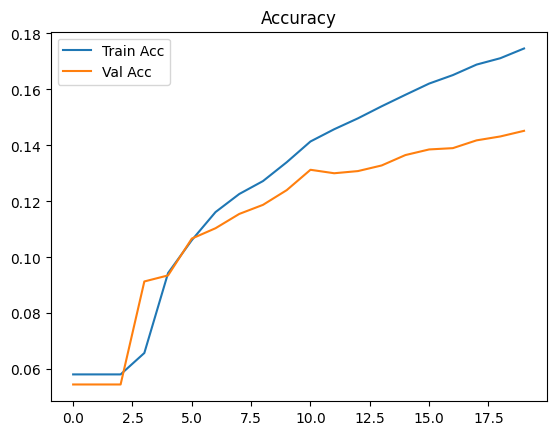

In [12]:
# Step 6: Train
history = model.fit(
    [x_train, y_train[:, :-1]],
    y_train[:, 1:][..., np.newaxis],
    epochs=20,
    batch_size=64,
    validation_data=([x_val, y_val[:, :-1]], y_val[:, 1:][..., np.newaxis])
)

# Step 7: Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy'); plt.show()

**With Attention Mechanism**

In [18]:
from tensorflow.keras.layers import Layer, Concatenate
import tensorflow as tf

summary_tokenizer.fit_on_texts(df['summary'])  # if not done yet

# Define vocab sizes (REQUIRED before using y_vocab_size)
y_vocab_size = len(summary_tokenizer.word_index) + 1

class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W1 = self.add_weight(shape=(input_shape[0][-1], input_shape[0][-1]), initializer='random_normal')
        self.W2 = self.add_weight(shape=(input_shape[1][-1], input_shape[0][-1]), initializer='random_normal')
        self.V = self.add_weight(shape=(input_shape[0][-1], 1), initializer='random_normal')

    def call(self, inputs):
        encoder_out, decoder_out = inputs
        score = tf.nn.tanh(tf.tensordot(encoder_out, self.W1, axes=[2, 0]) +
                           tf.expand_dims(tf.tensordot(decoder_out, self.W2, axes=[2, 0]), axis=1))
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.V, axes=[3, 0]), axis=1)
        context_vector = tf.reduce_sum(attention_weights * encoder_out, axis=1)
        return context_vector

In [19]:
from tensorflow.keras.layers import Dot, Activation, TimeDistributed, Dense, Concatenate

# Encoder
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_out, state_h, state_c = encoder_lstm(enc_emb)

# Decoder
decoder_inputs = Input(shape=(max_summary_len - 1,))
dec_emb_layer = Embedding(vocab_size, 256)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_out, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention
score = Dot(axes=[2, 2], name='attention_score')([decoder_out, encoder_out]) 
attention_weights = Activation('softmax', name='attention_weights')(score)
context = Dot(axes=[2, 1], name='context_vector')([attention_weights, encoder_out])

# Concatenate context and decoder output
concat = Concatenate(axis=-1)([context, decoder_out])

output = TimeDistributed(Dense(y_vocab_size, activation='softmax'))(concat)

model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 300, 256)  │  2,560,000 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 29, 256)   │  2,560,000 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, 300,      │    525,312 │ embedding_10[0][… │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ [(None, 29, 256), │    525,312 │ embedding_11[0][… │
│                     │ (None, 256),      │            │ lstm_10[0][1],    │
│                     │ (None, 256)]      │            │ lstm_10[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_score     │ (None, 29, 300)   │          0 │ lstm_11[0][0],    │
│ (Dot)               │                   │            │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 29, 300)   │          0 │ attention_score[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, 29, 256)   │          0 │ attention_weight… │
│ (Dot)               │                   │            │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 29, 512)   │          0 │ context_vector[0… │
│ (Concatenate)       │                   │            │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 29, 21835) │ 11,201,355 │ concatenate_2[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,371,979 (66.27 MB)

 Trainable params: 17,371,979 (66.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.0497 - loss: 8.9811 - val_accuracy: 0.0546 - val_loss: 7.1432
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - accuracy: 0.0687 - loss: 6.8548 - val_accuracy: 0.0866 - val_loss: 6.9258
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.0877 - loss: 6.6752 - val_accuracy: 0.0881 - val_loss: 6.8311
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step - accuracy: 0.0940 - loss: 6.5390 - val_accuracy: 0.1011 - val_loss: 6.7410
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.1093 - loss: 6.3893 - val_accuracy: 0.1098 - val_loss: 6.6709
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 153s 5s/step - accuracy: 0.1231 - loss: 6.2397 - val_accuracy: 0.1200 - val_loss: 6.6088
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.1305 - loss: 6.1086 - val_accuracy: 0.1236 - val_loss: 6.5677
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.1361 - loss: 6.0044 - val_accuracy: 0.1265 - v

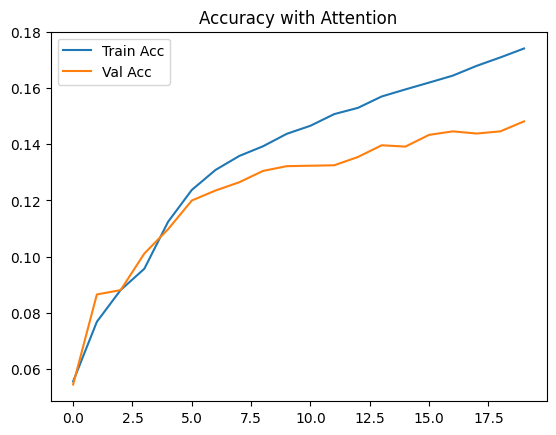

In [20]:
history2 = model.fit(
    [x_train, y_train[:, :-1]],
    y_train[:, 1:][..., np.newaxis],
    epochs=20,
    batch_size=64,
    validation_data=([x_val, y_val[:, :-1]], y_val[:, 1:][..., np.newaxis])
)

# Plot accuracy
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy with Attention'); plt.show()

[](http://)